## Motor Coefficients Training

Room temparature, 9v, 50% power train set: train1_room_9_500.csv

Load all train data...

In [1]:
from operator import index
# Import libraries for data manipulation
import pandas as pd
import numpy as np

# Import libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import ProbPlot

# Import libraries for building linear regression model using statsmodel
from statsmodels.formula.api import ols
import statsmodels.api as sm

# Importing Linear Regression from sklearn
from sklearn.linear_model import LinearRegression

# Import library for preparing data
from sklearn.model_selection import train_test_split
import sklearn.datasets as datasets
from sklearn.metrics import mean_squared_error, r2_score

# Import library for data preprocessing
from sklearn.preprocessing import MinMaxScaler

# For removal of the outliers
from scipy.stats import zscore

import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/drive')
D1 = pd.read_csv("/drive/MyDrive/Colab Notebooks/train1_room_9_500.csv")
D2 = pd.read_csv("/drive/MyDrive/Colab Notebooks/train2_room_6_to_12_500.csv")
D3 = pd.read_csv("/drive/MyDrive/Colab Notebooks/train3_room_9v_800.csv")
D4 = pd.read_csv("/drive/MyDrive/Colab Notebooks/train4_room_9v_1000.csv")
D5 = pd.read_csv("/drive/MyDrive/Colab Notebooks/train5_room_6_to_12_500.csv")
D6 = pd.read_csv("/drive/MyDrive/Colab Notebooks/train6_temp_6to18_v_6to12_500.csv")
D7 = pd.read_csv("/drive/MyDrive/Colab Notebooks/train7_temp_19to28_v_6to12_500.csv")
D8 = pd.read_csv("/drive/MyDrive/Colab Notebooks/train8_low_temp_9v_500.csv")

D = pd.concat([D1, D2, D3, D4, D5, D6, D7, D8], ignore_index=True)
D.drop_duplicates(inplace=True)
D = D.astype({'temp': 'float64'}, copy=False)

D['angle'] = D['angle'].abs() / 40.0
D['ispeed'] = (D['ispeed'] * D['dir']) / 400.0
D['temp'] = (D['temp'] + 100.0) / 200.0
D['volt'] = D['volt'] / 20.0
D['rtime'] = D['rtime'] * 10.0

D.drop(['dir'], axis='columns', inplace=True)
D.drop_duplicates(inplace=True)

#D = D[D['rtime'] < 0.05] # leave only short moves

print(D.head())

Mounted at /drive
   angle  rtime  ispeed  temp     volt  power
0  0.024   0.05   0.000  0.65  0.44935    0.5
2  0.018   0.05  -0.000  0.65  0.44880    0.5
3  0.024   0.05  -0.000  0.65  0.44945    0.5
4  0.060   0.10   0.000  0.65  0.44900    0.5
5  0.066   0.10   0.048  0.65  0.44920    0.5


In [2]:
D.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4479 entries, 0 to 5717
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   angle   4479 non-null   float64
 1   rtime   4479 non-null   float64
 2   ispeed  4479 non-null   float64
 3   temp    4479 non-null   float64
 4   volt    4479 non-null   float64
 5   power   4479 non-null   float64
dtypes: float64(6)
memory usage: 244.9 KB


In [3]:
D.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
angle,4479.0,0.119403,0.120384,0.00000,0.0300,0.072000,0.180000,1.038000
rtime,4479.0,0.354715,0.450857,0.02000,0.1000,0.100000,1.090000,1.250000
ispeed,4479.0,0.051557,0.143182,-0.61101,0.0000,0.033028,0.115597,0.943637
temp,4479.0,0.601486,0.051408,0.47000,0.5850,0.620000,0.645000,0.665000
volt,4479.0,0.457568,0.092611,0.29650,0.3963,0.448650,0.545500,0.607600
power,4479.0,0.528310,0.107709,0.50000,0.5000,0.500000,0.500000,1.000000


angle = f(time)

Remove outliers

In [4]:
# Remove outliers for specified columns
columns = ['angle', 'ispeed', 'volt', 'temp']
threshold = 3 # how many standard deviations away from the mean a point has to be to become an outlier

# Calculate z-scores for specified columns
z_scores = zscore(D[columns])

# Filter out rows where the absolute z-score is greater than the threshold for any column
D_no_outliers = D[(abs(z_scores) < threshold).all(axis=1)]

D_no_outliers.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
angle,4344.0,0.109269,0.100988,0.000000,0.0300,0.072000,0.168000,0.4800
rtime,4344.0,0.337776,0.441156,0.020000,0.1000,0.100000,0.200000,1.2500
ispeed,4344.0,0.045424,0.126907,-0.363302,0.0000,0.032878,0.099083,0.4800
temp,4344.0,0.601100,0.051494,0.470000,0.5850,0.615000,0.645000,0.6650
volt,4344.0,0.455952,0.092905,0.296500,0.3962,0.448550,0.545350,0.6076
power,4344.0,0.525506,0.101807,0.500000,0.5000,0.500000,0.500000,1.0000


In [5]:
D = D_no_outliers

Graph the data

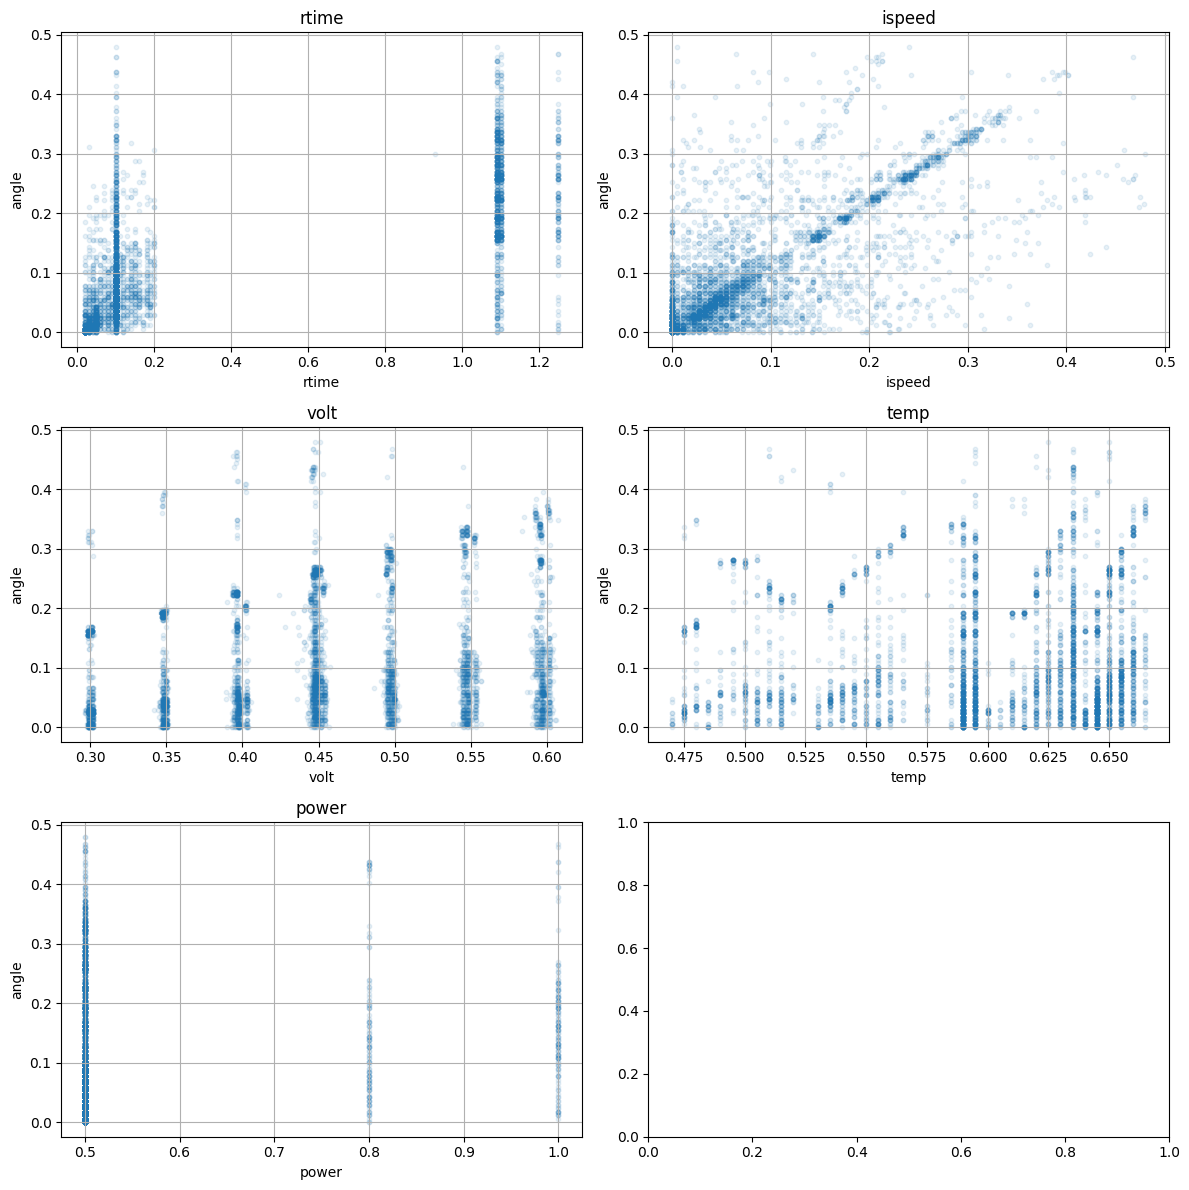

In [6]:
from matplotlib import pyplot as plt

xnames = ['rtime', 'ispeed', 'volt', 'temp', 'power']
fig, splt = plt.subplots(3, 2, figsize=(12, 12))
axes = splt.flatten()
yname = 'angle'
Y = D[yname].abs()

count = 0
for xname in xnames:
  X = D[xname].abs()
  axis = axes[count]
  axis.scatter(X, Y, s = 10, alpha = 0.1)
  axis.set_xlabel(xname)
  axis.set_ylabel(yname)
  axis.grid(True)
  axis.set_title(xname)
  count += 1

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

Correlation between values, should see a lot between time and angle (maybe not as no sign)

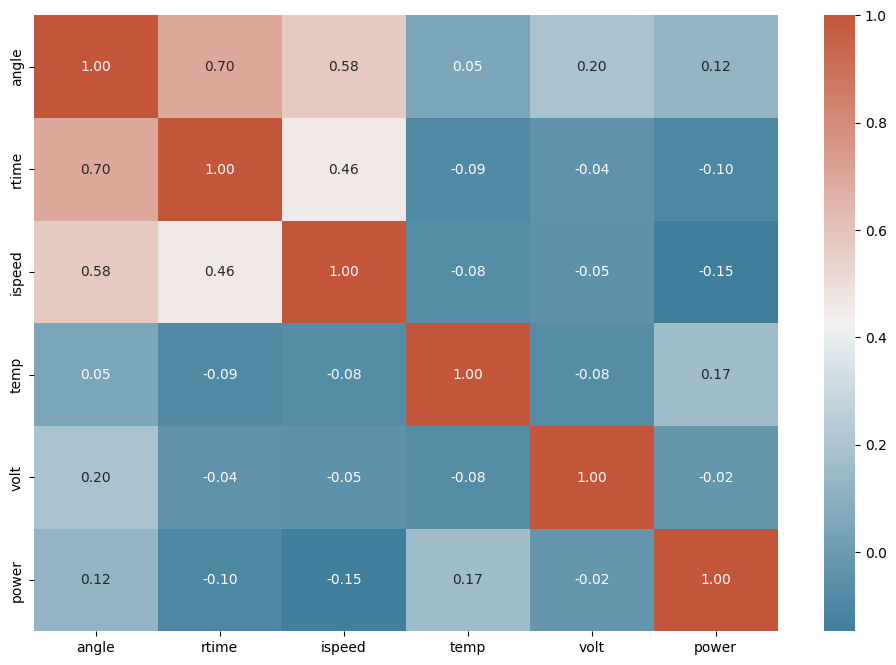

In [7]:
plt.figure(figsize = (12, 8))
cmap = sns.diverging_palette(230, 20, as_cmap = True)
sns.heatmap(D.corr(), annot = True, fmt = '.2f', cmap = cmap)
plt.show()

Split into learn and test as 75:25:

In [8]:
DM = D
Y = DM['rtime']
X = DM.drop(columns = {'rtime'})

# Add the intercept term
X = sm.add_constant(X)

# Splitting the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25 , random_state = 1)

In [9]:
DM.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
angle,4344.0,0.109269,0.100988,0.000000,0.0300,0.072000,0.168000,0.4800
rtime,4344.0,0.337776,0.441156,0.020000,0.1000,0.100000,0.200000,1.2500
ispeed,4344.0,0.045424,0.126907,-0.363302,0.0000,0.032878,0.099083,0.4800
temp,4344.0,0.601100,0.051494,0.470000,0.5850,0.615000,0.645000,0.6650
volt,4344.0,0.455952,0.092905,0.296500,0.3962,0.448550,0.545350,0.6076
power,4344.0,0.525506,0.101807,0.500000,0.5000,0.500000,0.500000,1.0000


Create a simple LR model

In [10]:
model = sm.OLS(Y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  rtime   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     877.4
Date:                Sun, 25 Feb 2024   Prob (F-statistic):               0.00
Time:                        20:30:34   Log-Likelihood:                -563.30
No. Observations:                3258   AIC:                             1139.
Df Residuals:                    3252   BIC:                             1175.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4064      0.071     19.810      0.000       1.267       1.546
angle          3.4872      0.068     51.363      0.000       3.354       3.620
ispeed        -0.1769      0.053     -3.334      0.001      -0.281      -0.073
temp          -0.9400      0.101     -9.328      0.000      -1.138      -0.742
volt          -0.9994      0.057    -17.470      0.000      -1.112      -0.887
power         -0.7981      0.052    -15.259      0.000      -0.901      -0.696
==============================================================================
Omnibus:                      341.797   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1272.044
Skew:                           0.482   Prob(JB):                    6.01e-277
Kurtosis:                       5.905   Cond. No.                         32.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Check how it predicts

In [11]:
# RMSE
def rmse(predictions, targets):
    return np.sqrt(((targets - predictions) ** 2).mean())
# MAPE
def mape(predictions, targets):
    return np.mean(np.abs((targets - predictions)) / targets) * 100
# MAE
def mae(predictions, targets):
    return np.mean(np.abs((targets - predictions)))

# Model Performance on test and train data
def model_pref(olsmodel, x_train, x_test, y_train, y_test):

    # Insample Prediction
    y_pred_train = olsmodel.predict(x_train)
    y_observed_train = y_train

    # Prediction on test data
    y_pred_test = olsmodel.predict(x_test)
    y_observed_test = y_test

    print(
        pd.DataFrame(
            {
                "Data": ["Train", "Test"],
                "RMSE": [
                    rmse(y_pred_train, y_observed_train),
                    rmse(y_pred_test, y_observed_test),
                ],
                "MAE": [
                    mae(y_pred_train, y_observed_train),
                    mae(y_pred_test, y_observed_test),
                ],
                "MAPE": [
                    mape(y_pred_train, y_observed_train),
                    mape(y_pred_test, y_observed_test),
                ],
            }
        )
    )


# Checking model performance
model_pref(model, X_train, X_test, Y_train, Y_test)

    Data      RMSE       MAE        MAPE
0  Train  0.287642  0.204947  159.851453
1   Test  0.290712  0.206976  165.711875




---

